This will need to be done more customizably in .py code, but an example model comparison setup will be made here which we can eventually refactor for comparing the performance of a Vision Transformer vs. Some out of the box ResNet

In [29]:

from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import sys
sys.path.append('../vit_pytorch/')
sys.path.append('../')

from vit import ViT
from recorder import Recorder # import the Recorder and instantiate

#from vit_pytorch.efficient import ViT

In [30]:
print(f"Torch: {torch.__version__}")


Torch: 1.8.1+cu102


In [31]:

# Training settings
batch_size = 64
epochs = 10
lr = 3e-5
gamma = 0.7
seed = 42

In [32]:

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [33]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'


Input Data

In [36]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Grayscale(num_output_channels=1),
                       transforms.ToTensor(),
                       transforms.Normalize((0.,), (1.,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                       transforms.Grayscale(num_output_channels=1),
                       transforms.ToTensor(),
                       transforms.Normalize((0.,), (1.,))
                   ])),
    batch_size=1000, shuffle=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ../data/cifar-100-python.tar.gz to ../data


In [28]:
# this does not have validation, so would not recomend

In [ ]:
args.num_dimensions = 

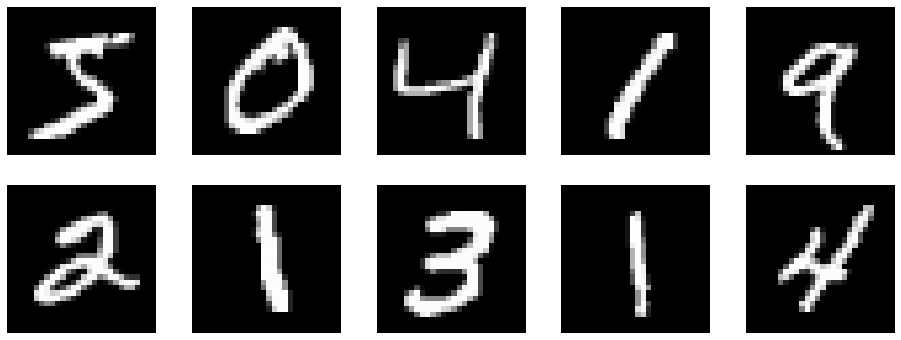

In [7]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy(),cmap='gray')
    plt.axis('off');

In [9]:
rec = Recorder()

dim = 128
image_size = 28
patch_size = image_size // 7
channels = 1
depth = 64
heads = 32
mlp_dim = 128
dropout = .2
num_classes = output_size
model = ViT(
    dim=dim,
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    channels=channels,
    depth = depth,
    heads=heads, 
    mlp_dim=mlp_dim,
    dropout=dropout
).to(device)

In [10]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [11]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader: # interchangable with val for this toy experiment
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / test_loader.dataset.__len__()
            epoch_val_loss += val_loss / test_loader.dataset.__len__()

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.6543 - acc: 0.3777 - val_loss : 0.0011 - val_acc: 0.0006



  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
from torchvision.models import resnet18

In [15]:
model = resnet18()

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  